In [1]:
%%capture
!pip install skyfield pytz astral

In [9]:
LAT, LON = (20.99365, 105.86950277777778)
ALTITUDE = 0
HORIZON = 10
TIMEZONE = 'Asia/Ho_Chi_Minh'

In [3]:
from skyfield.api import load, Topos

EPH = load('de421.bsp')

location = Topos(
    latitude_degrees=LAT,
    longitude_degrees=LON,
    elevation_m=ALTITUDE,
)
observer = EPH['earth'] + location
observer

[#################################] 100% de421.bsp


<VectorSum of 3 vectors:
 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 3 EARTH BARYCENTER
 'de421.bsp' segment 3 EARTH BARYCENTER -> 399 EARTH
 Geodetic 399 EARTH -> IERS2010 latitude +20.9936 N longitude 105.8695 E elevation 0.0 m>

In [7]:
EPH['moon']

<VectorSum of 2 vectors:
 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 3 EARTH BARYCENTER
 'de421.bsp' segment 3 EARTH BARYCENTER -> 301 MOON>

In [8]:
from datetime import datetime, timezone
from astral import LocationInfo
from astral.sun import sun

def get_sunset_time(dt, latitude, longitude):
    location = LocationInfo(latitude=latitude, longitude=longitude)
    s = sun(location.observer, date=dt.date())
    return s['dusk']

dt = datetime.now(timezone.utc)
sunset_dt = get_sunset_time(dt, LAT, LON)
sunset_dt

datetime.datetime(2024, 11, 14, 10, 38, 59, 996908, tzinfo=datetime.timezone.utc)

In [66]:
import pytz
import pprint

from datetime import timedelta

LOCAL_TIMEZONE = pytz.timezone(TIMEZONE)

def is_out_of_range(t):
    today = datetime.now(pytz.utc)
    future_dt = today + timedelta(days=30)
    current_dt = t.astimezone(LOCAL_TIMEZONE)
    return current_dt > future_dt

def is_night(dt, latitude, longitude):
    location = LocationInfo(latitude=latitude, longitude=longitude)
    s = sun(location.observer, date=dt.date())
    return  dt <= s['dawn'] and dt >= s['dusk']

def get_position(planet_name, observer, time):
    planet = EPH[planet_name]
    astrometric = observer.at(time).observe(planet)
    return astrometric.apparent().altaz()

def is_above_horizon(position, horizon):
  alt, az, _ = position

  if alt.degrees < horizon:
    return False

  return True

dt = datetime.now(timezone.utc)
ts = load.timescale()

night_dt = get_sunset_time(dt, LAT, LON)
t = ts.from_datetime(night_dt)

observations = {}

while not is_out_of_range(t):
  dt = t.utc_datetime()

  if not is_night(dt, LAT, LON):
      night_dt = get_sunset_time(dt, LAT, LON)

      t = ts.from_datetime(night_dt)
      t += timedelta(days=1)

  position = get_position('moon', observer, t)

  is_visible = is_above_horizon(position, HORIZON)
  if is_visible:
      alt, az, distance = position

      local_dt = t.astimezone(LOCAL_TIMEZONE)

      event_time = local_dt.strftime('%H:%M:%S')
      event_date = local_dt.strftime('%Y-%m-%d')

      observations[event_date] = [] if event_date not in observations else observations[event_date]

      observations[event_date].append({
          'event_time': event_time,
          'azimuth': az.degrees,
          'altitude': alt.degrees,
          'distance': distance.km,
      })

  t += timedelta(hours=1)

# pp = pprint.PrettyPrinter(indent=4)
# pp.pprint(observations)

In [67]:
from statistics import mean

observations_summary = {}
for date, stats in observations.items():
    observations_summary[date] = {
        'altitude': mean(stat['altitude'] for stat in stats),
        'azimuth': mean(stat['azimuth'] for stat in stats),
        'distance': mean(stat['distance'] for stat in stats)
    }

# pp.pprint(observations_summary)

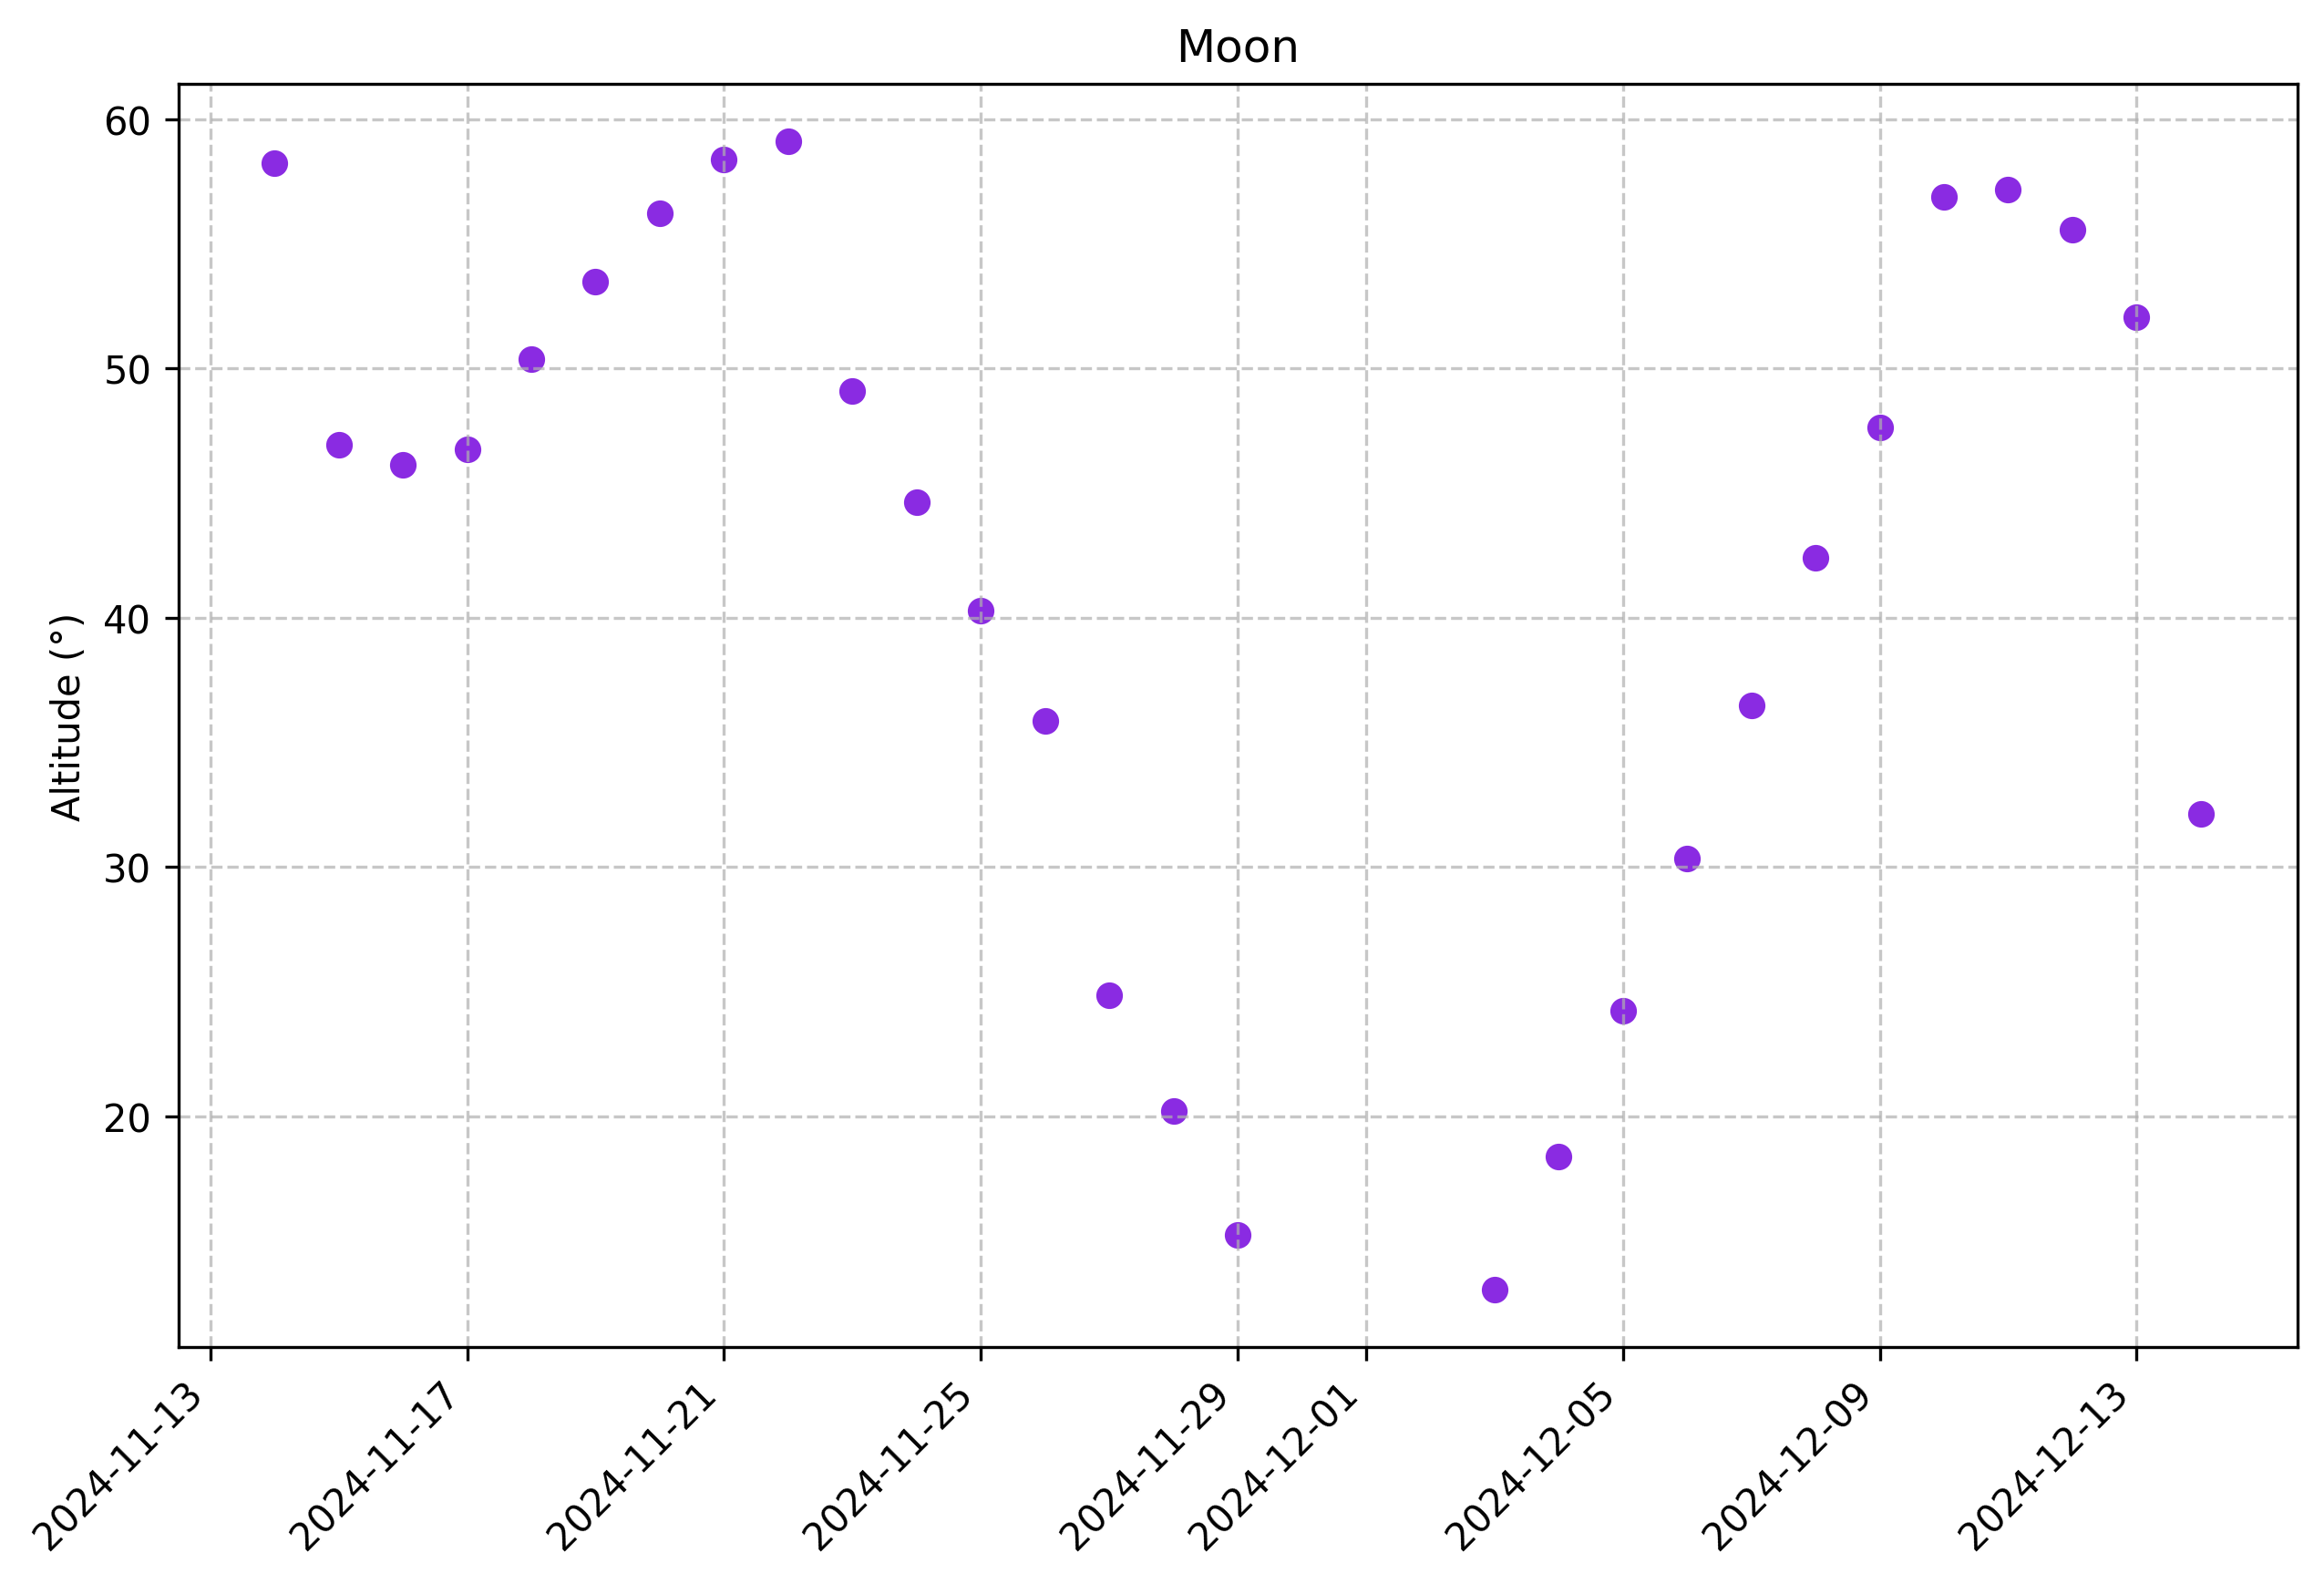

In [68]:
import matplotlib.pyplot as plt

def plot_altitude(observations):
  data = [observations[date]['altitude'] for date in observations.keys()]
  dates = [mdates.datestr2num(date) for date in observations.keys()]

  plt.style.use('default')
  plt.figure(figsize=(10, 6), dpi=300)
  plt.scatter(dates, data, color='blueviolet')

  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
  plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
  plt.xticks(rotation=45, ha='right')

  plt.title('Moon')
  plt.ylabel('Altitude (°)')

  plt.grid(True, linestyle='--', alpha=0.7)
  plt.show()

plot_altitude(observations_summary)

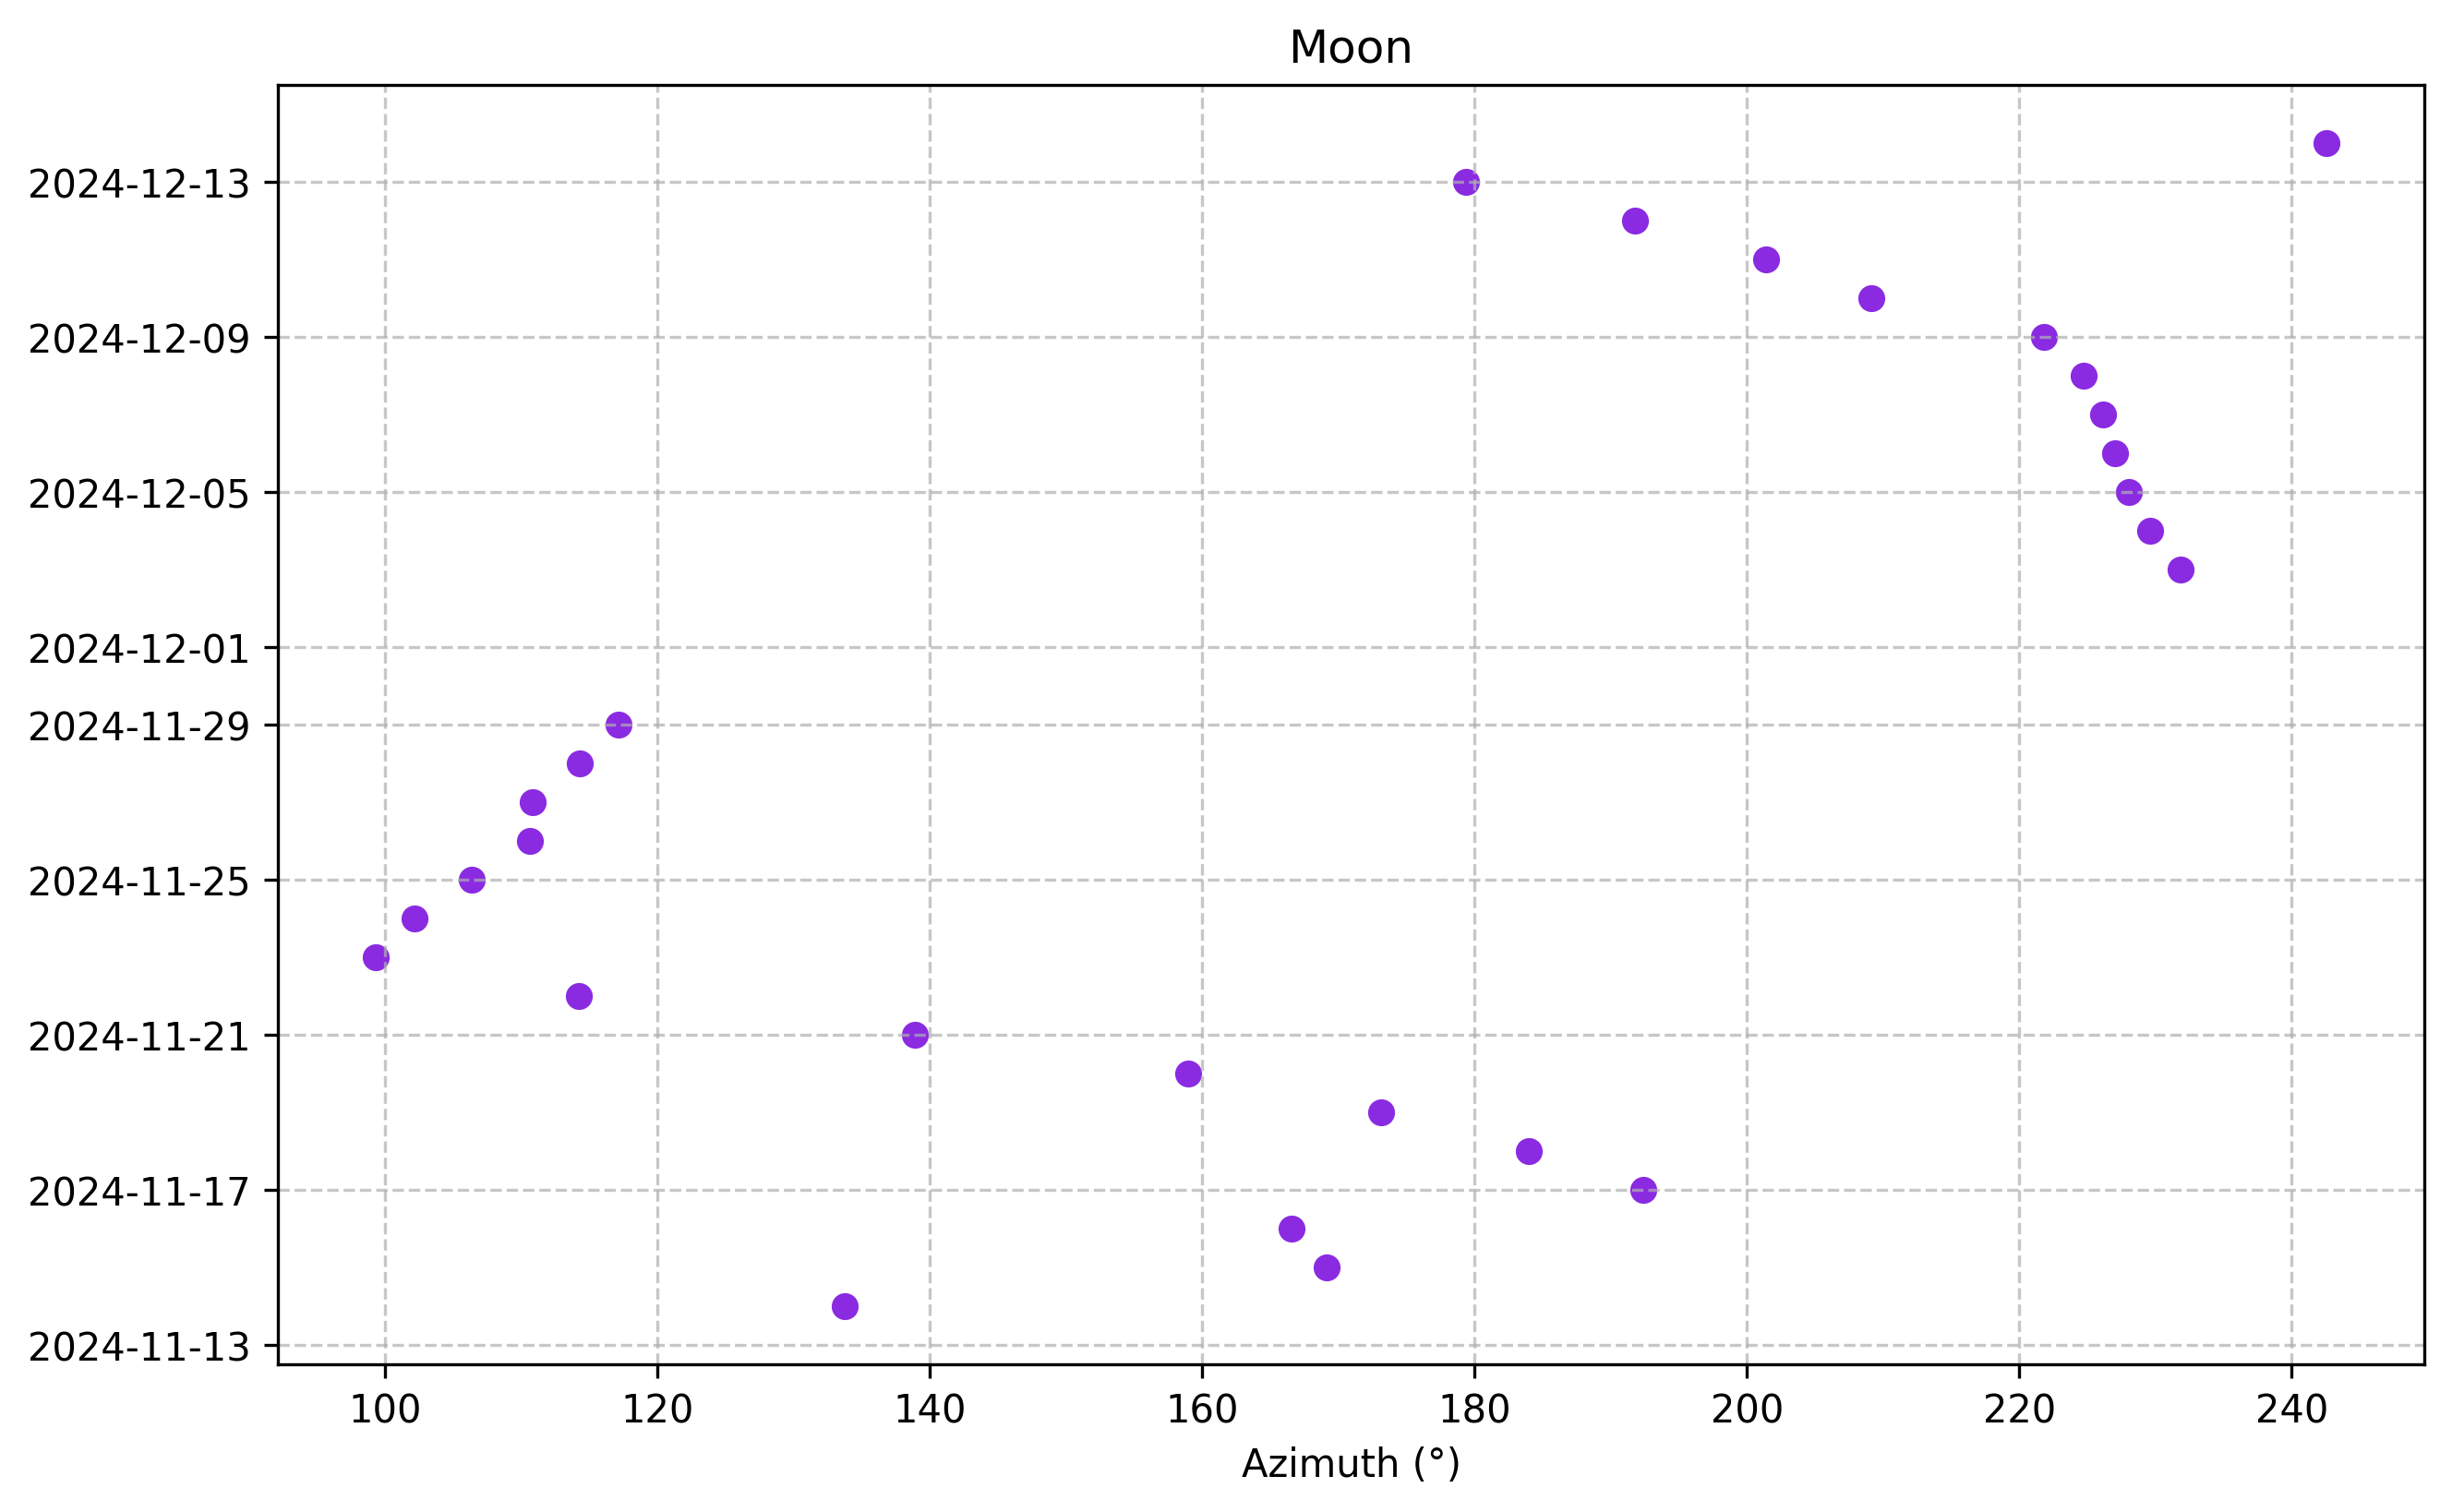

In [69]:
def plot_azimuth(observations):
  data = [observations[date]['azimuth'] for date in observations.keys()]
  dates = [mdates.datestr2num(date) for date in observations.keys()]

  plt.style.use('default')
  plt.figure(figsize=(10, 6), dpi=300)
  plt.scatter(data, dates, color='blueviolet')

  plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
  plt.gca().yaxis.set_major_locator(mdates.AutoDateLocator())

  plt.title('Moon')
  plt.xlabel('Azimuth (°)')

  plt.grid(True, linestyle='--', alpha=0.7)
  plt.show()

plot_azimuth(observations_summary)

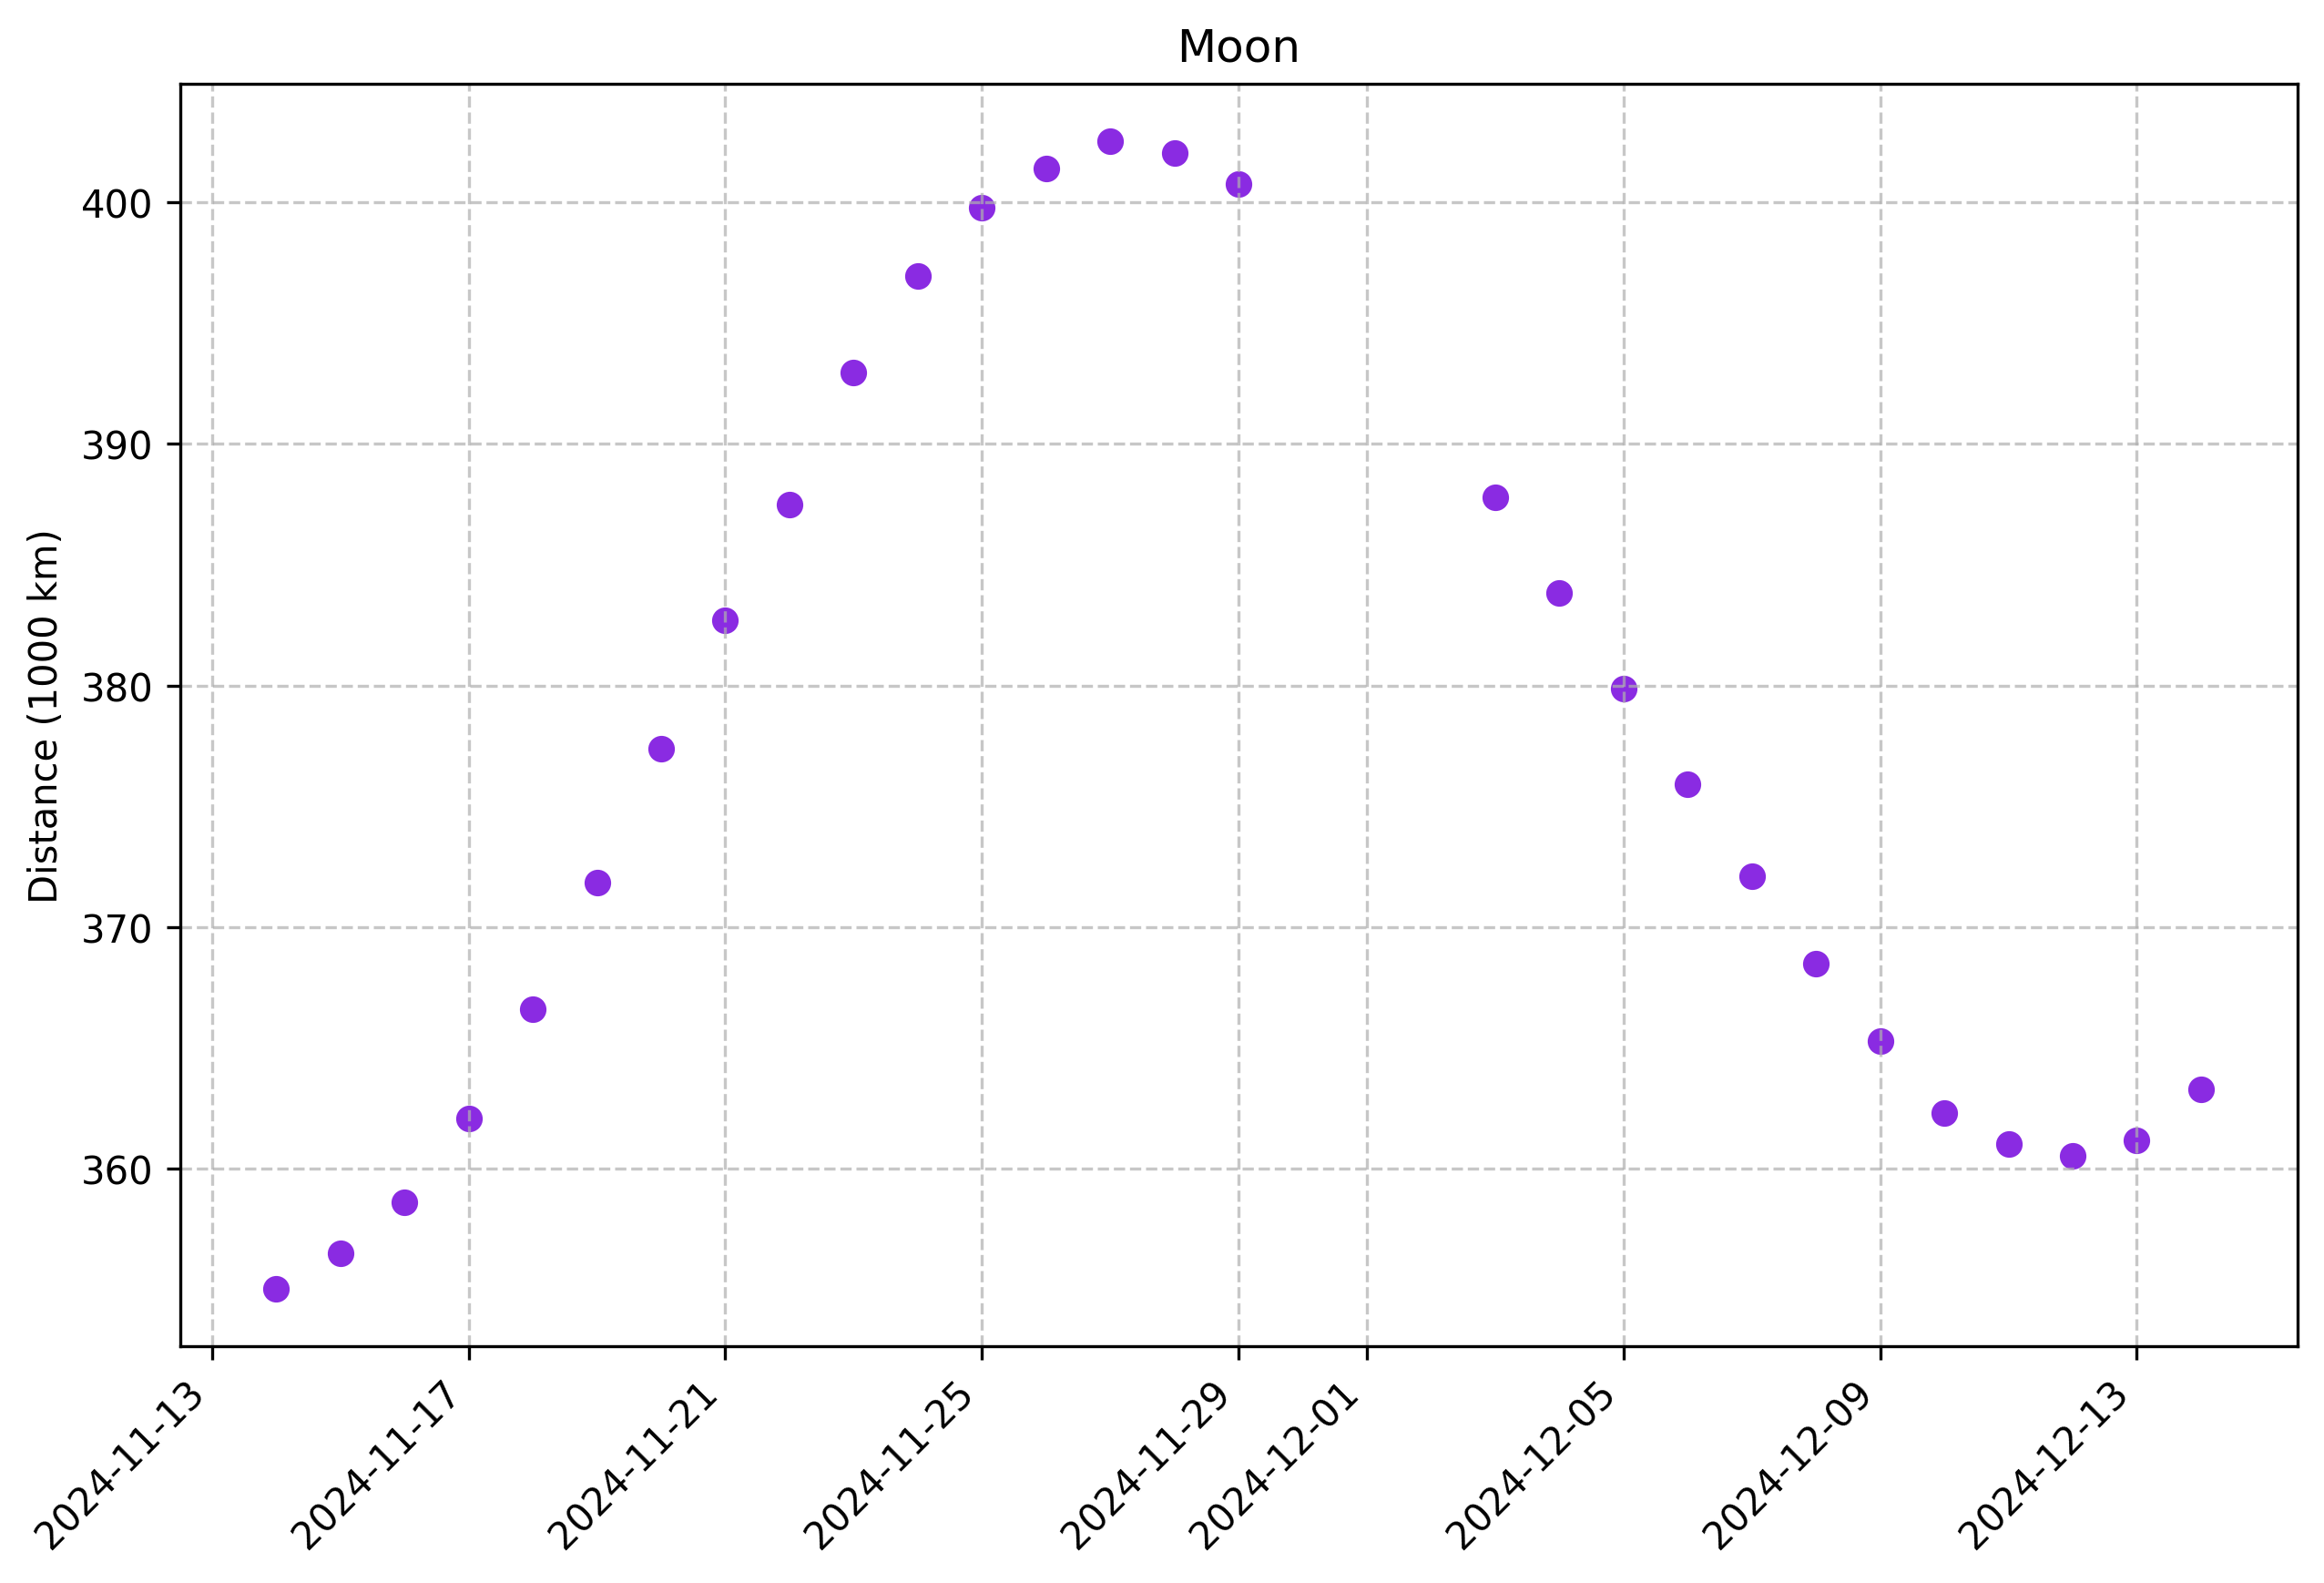

In [70]:
import matplotlib.dates as mdates

def plot_distance(observations):
  data = [observations[date]['distance'] / 1000.0 for date in observations.keys()]
  dates = [mdates.datestr2num(date) for date in observations.keys()]

  plt.style.use('default')
  plt.figure(figsize=(10, 6), dpi=300)
  plt.scatter(dates, data, color='blueviolet')

  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
  plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
  plt.xticks(rotation=45, ha='right')

  plt.title('Moon')
  plt.ylabel('Distance (1000 km)')

  plt.grid(True, linestyle='--', alpha=0.7)
  plt.show()

plot_distance(observations_summary)